In [ ]:
!unzip CASIA1.zip
!pip install --upgrade albumentations
!pip install pytorch-ignite

Archive:  CASIA1.zip
   creating: CASIA1/1/
  inflating: CASIA1/1/001_1_1.jpg    
  inflating: CASIA1/1/001_1_2.jpg    
  inflating: CASIA1/1/001_1_3.jpg    
 extracting: CASIA1/1/001_2_1.jpg    
  inflating: CASIA1/1/001_2_2.jpg    
  inflating: CASIA1/1/001_2_3.jpg    
  inflating: CASIA1/1/001_2_4.jpg    
   creating: CASIA1/10/
  inflating: CASIA1/10/010_1_1.jpg   
  inflating: CASIA1/10/010_1_2.jpg   
  inflating: CASIA1/10/010_1_3.jpg   
  inflating: CASIA1/10/010_2_1.jpg   
  inflating: CASIA1/10/010_2_2.jpg   
  inflating: CASIA1/10/010_2_3.jpg   
  inflating: CASIA1/10/010_2_4.jpg   
   creating: CASIA1/100/
  inflating: CASIA1/100/100_1_1.jpg  
  inflating: CASIA1/100/100_1_2.jpg  
  inflating: CASIA1/100/100_1_3.jpg  
  inflating: CASIA1/100/100_2_1.jpg  
 extracting: CASIA1/100/100_2_2.jpg  
 extracting: CASIA1/100/100_2_3.jpg  
  inflating: CASIA1/100/100_2_4.jpg  
   creating: CASIA1/101/
  inflating: CASIA1/101/101_1_1.jpg  
  inflating: CASIA1/101/101_1_2.jpg  
  inflat

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json 
from PIL import Image
import albumentations as A
import cv2
from google.colab.patches import cv2_imshow
import torch.nn as nn

In [ ]:
class IrisDataset(Dataset):
    def __init__(self, root, transform, train=True):
        root = Path(root)
        labels_file = root / 'labels_{}.json'.format('train' if train else 'test')
        labels = json.load(labels_file.open('r'))
        self.filenames = list(labels.keys())
        self.labels = [labels[f] for f in self.filenames]
        self.root = root
        self.transform = transform
    
    def load_image(self, filepath):

        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

        # Augment an image
        transformed = self.transform(image=image, keypoints=[])
        transformed_image = transformed["image"]
        transformed_image = cv2.cvtColor(transformed_image,cv2.COLOR_RGB2GRAY)
        transformed_image = torch.tensor(transformed_image/256, dtype=torch.float32)
        return transformed_image

    def __getitem__(self, idx):
        filepath = (self.root / self.filenames[idx]).__str__()
        label = self.labels[idx]
        x, y, r, x_o, y_o,  r_o = label

        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

        # Augment an image
        transformed = self.transform(image=image, keypoints=[(x, y, r), (x_o, y_o, r_o)])
        transformed_image = transformed["image"]
        [(x, y, r), (x_o, y_o, r_o)] = transformed['keypoints']
        height, width, *_ = transformed_image.shape

        transformed_image = cv2.cvtColor(transformed_image,cv2.COLOR_RGB2GRAY)

        transformed_image = torch.tensor(transformed_image/256, dtype=torch.float32)

        # transform
        # image = torch.tensor(np.array(image) / 255, dtype=torch.float32)
        
        label = x/width, y/width, r/width, x_o/width, y_o/width, r_o/width
        label = torch.tensor(label, dtype=torch.float32)
        return (transformed_image, label)

    def __len__(self):
        return len(self.labels)


len trainset: 588
len testset: 168


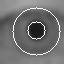

In [ ]:
train_transform = A.Compose([                       
    # A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=(-0.0625, 0.0625), scale_limit=(-0.1, 0.1), rotate_limit=45),
    A.RandomCrop(width=256, height=256),
    A.Resize(height=64, width=64),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRain(),
    # A.RandomSunFlare(),
], keypoint_params=A.KeypointParams(format="xys"))

test_transform = A.Compose([                       
    # A.HorizontalFlip(p=0.5),
    # A.ShiftScaleRotate(shift_limit=(-0.0625, 0.0625), scale_limit=(-0.1, 0.1), rotate_limit=45),
    A.RandomCrop(width=256, height=256),
    A.Resize(height=64, width=64),
    # A.RandomBrightnessContrast(p=0.2),
    # A.RandomRain(),
    # A.RandomSunFlare(),
], keypoint_params=A.KeypointParams(format="xys"))



trainset = IrisDataset('CASIA1', transform=train_transform, train=True)
testset = IrisDataset('CASIA1', transform=test_transform, train=False)
print('len trainset:', len(trainset))
print('len testset:', len(testset))
image, labels = trainset[0]
image = image.numpy() * 256
x, y, r, x_o, y_o, r_o = labels
# print(labels)
h, w = image.shape
image = cv2.circle(image, (int(x*w),int(y*w)), int(r*w), (255,), 1)
image = cv2.circle(image, (int(x_o*w),int(y_o*w)), int(r_o*w), (255,), 1)
cv2_imshow(image)


In [ ]:
import torchvision.models as models


class YanNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet18 = models.resnet18()
        resnet18.fc = nn.Linear(resnet18.fc.in_features, 6)
        self.resnet18 = resnet18
    
    def forward(self, x):
        assert x.ndim == 3
        x = torch.unsqueeze(x, 1).expand(-1, 3, -1, -1)
        x = self.resnet18(x)
        x = torch.sigmoid(x)
        return x


# images, labels = next(iter(train_loader))
# images = images.to('cuda')
# model = YanNet().cuda()
# outputs = model(images)

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch.optim.lr_scheduler import ExponentialLR

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(testset, batch_size=32, shuffle=False)

model = YanNet().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = nn.SmoothL1Loss(beta=0.1)
# criterion = nn.L1Loss()


trainer = create_supervised_trainer(model, optimizer, criterion, device='cuda')

val_metrics = {
    "mse": Loss(criterion)
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device='cuda')

@trainer.on(Events.ITERATION_COMPLETED(every=1))
def log_training_loss(trainer):
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.4f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.4f}")
    scheduler.step()

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg loss: {metrics['mse']:.4f}")

trainer.run(train_loader, max_epochs=100)


Epoch[1] Loss: 0.0913
Epoch[1] Loss: 0.0742
Epoch[1] Loss: 0.0516
Epoch[1] Loss: 0.0297
Epoch[1] Loss: 0.0363
Epoch[1] Loss: 0.0392
Epoch[1] Loss: 0.0480
Epoch[1] Loss: 0.0418
Epoch[1] Loss: 0.0405
Epoch[1] Loss: 0.0364
Epoch[1] Loss: 0.0383
Epoch[1] Loss: 0.0416
Epoch[1] Loss: 0.0333
Epoch[1] Loss: 0.0315
Epoch[1] Loss: 0.0364
Epoch[1] Loss: 0.0392
Epoch[1] Loss: 0.0314
Epoch[1] Loss: 0.0278
Epoch[1] Loss: 0.0268
Training Results - Epoch: 1  Avg loss: 0.0291
Validation Results - Epoch: 1  Avg loss: 0.0272
Epoch[2] Loss: 0.0262
Epoch[2] Loss: 0.0247
Epoch[2] Loss: 0.0218
Epoch[2] Loss: 0.0222
Epoch[2] Loss: 0.0171
Epoch[2] Loss: 0.0270
Epoch[2] Loss: 0.0207
Epoch[2] Loss: 0.0251
Epoch[2] Loss: 0.0176
Epoch[2] Loss: 0.0219
Epoch[2] Loss: 0.0217
Epoch[2] Loss: 0.0212
Epoch[2] Loss: 0.0237
Epoch[2] Loss: 0.0173
Epoch[2] Loss: 0.0187
Epoch[2] Loss: 0.0194
Epoch[2] Loss: 0.0155
Epoch[2] Loss: 0.0194
Epoch[2] Loss: 0.0199
Training Results - Epoch: 2  Avg loss: 0.0267
Validation Results - Epo

State:
	iteration: 1900
	epoch: 100
	epoch_length: 19
	max_epochs: 100
	output: 0.01137655321508646
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

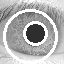

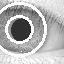

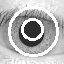

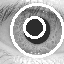

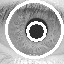

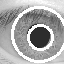

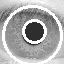

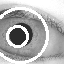

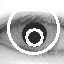

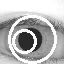

In [ ]:
testset = IrisDataset('CASIA1', transform=transform, train=False)
# img0 = testset.load_image('/content/photo_2021-11-10_18-40-39 (1).jpg')
# img0 = testset.load_image('/content/CASIA1/10/010_1_1.jpg')

for i in range(10):
    img0, label = testset[i]
    outputs = model(torch.unsqueeze(img0.to('cuda'), 0))
    x, y, r, x_o, y_o, r_o = outputs.flatten().tolist()
    # print(outputs.flatten().tolist())
    # print(label)
    # label = torch.tensor(label)
    # outputs = outputs.cpu().flatten()
    # mse = torch.sqrt(((label - outputs)**2).mean())
    # print(mse)
    # mse = criterion(label, outputs)
    # print(mse)

    image = img0
    image = image.numpy() * 256
    # print(labels)
    h, w = image.shape
    image = cv2.circle(image, (int(x*w),int(y*w)), int(r*w), (255,), 2)
    image = cv2.circle(image, (int(x_o*w),int(y_o*w)), int(r_o*w), (255,), 2)
    cv2_imshow(image)
